/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:17:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Comparison:
                    time  accuracy  precision    recall        f1
Random Forest   4.082507  0.984372   0.980053  0.991622  0.985804
XGBoost         0.907487  0.995624   0.996190  0.995811  0.996001
CatBoost        7.193141  0.997708   0.997337  0.998477  0.997907
MLP            38.388936  0.929985   0.935693  0.936405  0.936049

✅ Best model: CatBoost


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


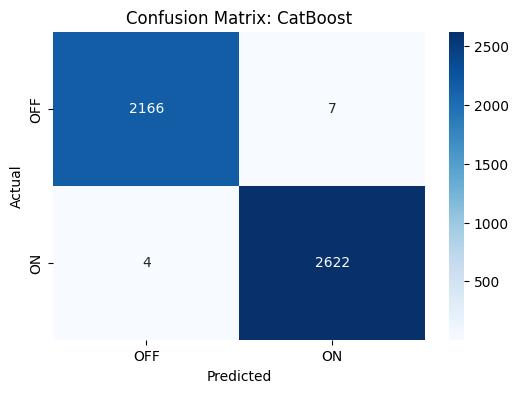

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

df = pd.read_csv("Irrigation Datasetm.csv")

df = df.drop(columns=['ph', 'rainfall', 'N', 'P', 'K'], errors='ignore')

le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])

X = df.drop(columns=['Status'])
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

start = time.time()
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
results['Random Forest'] = {
    'time': time.time() - start,
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred)
}

# XGBoost
start = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
results['XGBoost'] = {
    'time': time.time() - start,
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred)
}

# CatBoost
start = time.time()
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
results['CatBoost'] = {
    'time': time.time() - start,
    'accuracy': accuracy_score(y_test, cat_pred),
    'precision': precision_score(y_test, cat_pred),
    'recall': recall_score(y_test, cat_pred),
    'f1': f1_score(y_test, cat_pred)
}

# MLP
start = time.time()
mlp = MLPClassifier(max_iter=500)
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_test_scaled)
results['MLP'] = {
    'time': time.time() - start,
    'accuracy': accuracy_score(y_test, mlp_pred),
    'precision': precision_score(y_test, mlp_pred),
    'recall': recall_score(y_test, mlp_pred),
    'f1': f1_score(y_test, mlp_pred)
}

results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

best_model = results_df['f1'].idxmax()
print(f"\n✅ Best model: {best_model}")

if best_model == 'Random Forest':
    best_pred = rf_pred
elif best_model == 'XGBoost':
    best_pred = xgb_pred
elif best_model == 'CatBoost':
    best_pred = cat_pred
else:
    best_pred = mlp_pred

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.title(f'Confusion Matrix: {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_rrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_val = np.mean(y_true)
    return rmse / mean_val if mean_val != 0 else np.nan

for model_name, pred in zip(
    ['Random Forest', 'XGBoost', 'CatBoost', 'MLP'],
    [rf_pred, xgb_pred, cat_pred, mlp_pred]
):
    mae = mean_absolute_error(y_test, pred)
    rrmse = compute_rrmse(y_test, pred)
    results[model_name]['mae'] = mae
    results[model_name]['rrmse'] = rrmse

results_df = pd.DataFrame(results).T
print("\n🔍 Updated Model Comparison with RRMSE and MAE:")
print(results_df[['time', 'accuracy', 'precision', 'recall', 'f1', 'mae', 'rrmse']])



🔍 Updated Model Comparison with RRMSE and MAE:
                    time  accuracy  precision    recall        f1       mae  \
Random Forest   4.082507  0.984372   0.980053  0.991622  0.985804  0.015628   
XGBoost         0.907487  0.995624   0.996190  0.995811  0.996001  0.004376   
CatBoost        7.193141  0.997708   0.997337  0.998477  0.997907  0.002292   
MLP            38.388936  0.929985   0.935693  0.936405  0.936049  0.070015   

                  rrmse  
Random Forest  0.228461  
XGBoost        0.120890  
CatBoost       0.087494  
MLP            0.483560  


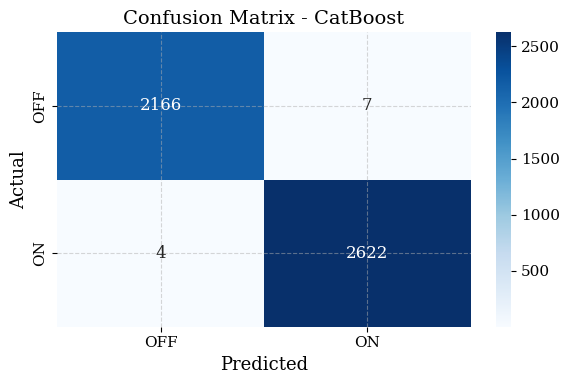

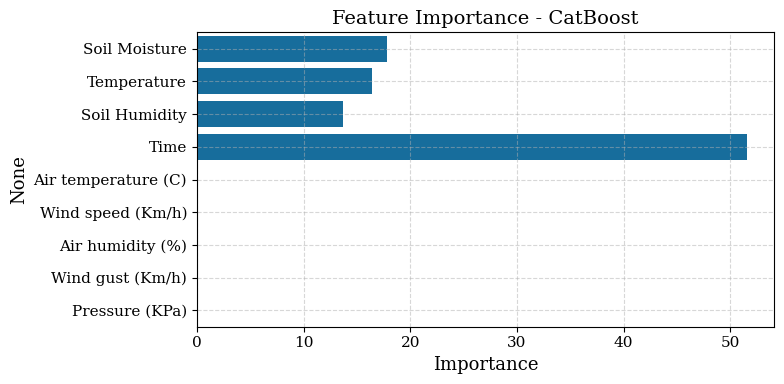

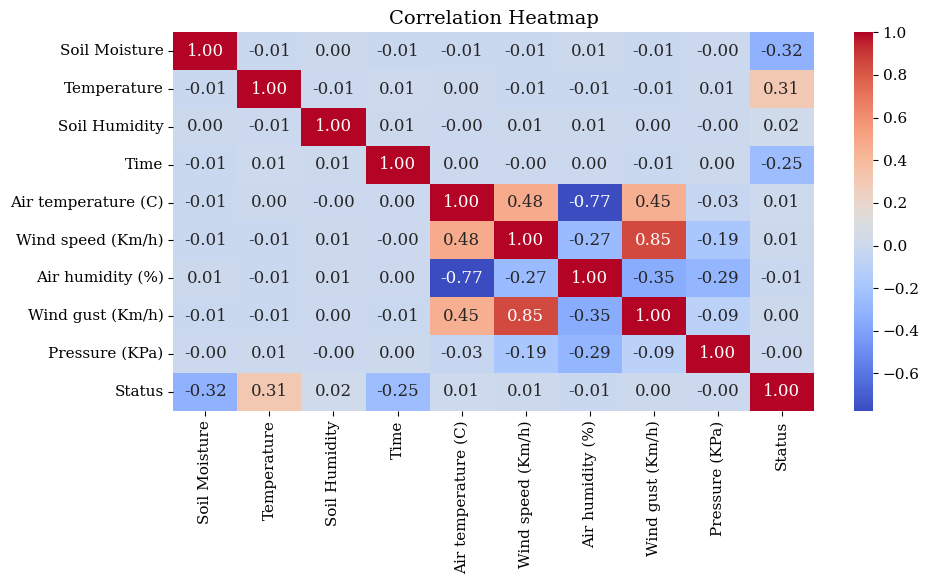

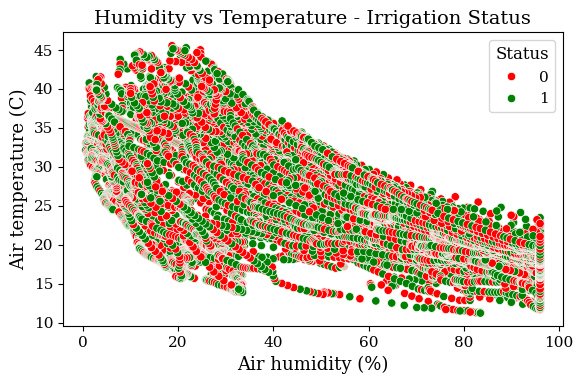

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from matplotlib.colors import ListedColormap
import os

os.makedirs("plots", exist_ok=True)

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})
sns.set_palette("colorblind")

df = pd.read_csv("Irrigation Datasetm.csv")
df = df.drop(columns=['ph', 'rainfall', 'N', 'P', 'K'], errors='ignore')

label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

X = df.drop('Status', axis=1)
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['OFF', 'ON'], yticklabels=['OFF', 'ON'])
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("plots/confusion_matrix_catboost.pdf", dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
importances = model.get_feature_importance()
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - CatBoost")
plt.xlabel("Importance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("plots/feature_importance.pdf", dpi=300)
plt.show()


plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("plots/correlation_heatmap.pdf", dpi=300)
plt.show()


# Figure % illustrates the dispersion of irrigation decisions based on environmental conditions.
# Although a general inverse correlation exists between humidity and temperature, their combined
# influence does not strongly separate irrigation classes, highlighting the need for more complex, multivariate models.
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='Air humidity (%)', y='Air temperature (C)', hue='Status', palette=['red', 'green'])
plt.title("Humidity vs Temperature - Irrigation Status")
plt.tight_layout()
plt.savefig("plots/humidity_vs_temperature.pdf", dpi=300)
plt.show()

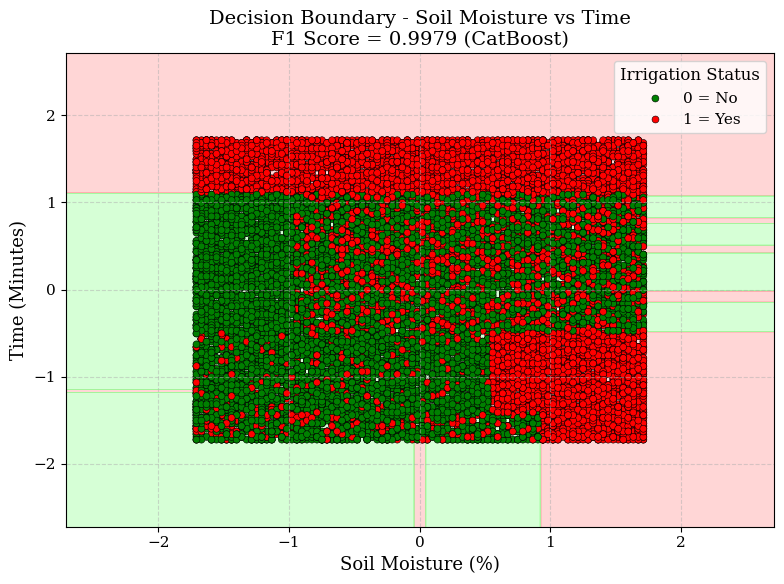

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

features_for_boundary = ['Soil Moisture', 'Time']
X_plot = X_train[features_for_boundary]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_plot)

xx, yy = np.meshgrid(np.linspace(X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1, 500),
                     np.linspace(X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

model_2d = CatBoostClassifier(verbose=0)
model_2d.fit(X_plot, y_train)
Z = model_2d.predict(scaler.inverse_transform(grid)).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=ListedColormap(['#ff9999', '#99ff99']), alpha=0.4)

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y_train, palette=['red', 'green'], edgecolor='black', s=25)

plt.title("Decision Boundary - Soil Moisture vs Time\nF1 Score = 0.9979 (CatBoost)")
plt.xlabel("Soil Moisture (%)")
plt.ylabel("Time (Minutes)")
plt.legend(title='Irrigation Status', labels=['0 = No', '1 = Yes'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()


